In [5]:
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
from sympy import *

#Dados do problema:

n_nos=5 #Número de nós
n_el=4 #Número de elementos
# número de cada nó e coordenadas x dos mesmos
no = [0,  1,   2,   3,   4       ]
x  = [0,  2,   4,   6,   8       ]


In [6]:
# Matriz de conectividade: [elemento, Número da seção, primeiro nó, segundo nó]
conec = np.array([[0,   0,   0,   1],
                  [1,   0,   1,   2],
                  [2,   0,   2,   3],
                  [3,   0,   3,   4]])

n_sec=1 # Número de seções distintas presentes na estrutura

# Matriz de Seções: [número da seção, área, módulo de elasticidade, momento de inércia,
# distância vertical à linha neutra, cf]
secoes = np.array([[0, .2*.6, 200e9, .2*.6**3/12, .6/2, 4e8]])

In [7]:
# Carregamentos nodais (Fzão da estrutura)
n_forcas=1 #Número de nós na qual atuam forças
#Matriz de forças [nó (primeiro nó é o nó zero e não 1), força em y, momento em z]
forcas=np.matrix([4,      -2e3,    4e3])

In [8]:
# Carregamentos equivalentes (Feq da estrutura)
n_eq=4 # número de elementos que contem carregamentos equivalentes
# Matriz de carregamento equivalente = [elemento, tipo de carregamento, intensidade, posição (para o caso de carregamento concentrado entre nós)]
w_eq=np.array([[0, 1, -5e3, 0],
               [1, 1, -5e3, 0],
               [2, 1, -5e3, 0],
               [3, 1, -5e3, 0]])
# LEMBRETE: os sinais das forças devem seguir o sistema LOCAL do elemento!

In [9]:
# Apoios
n_rest=1  #número de nós restringidos
#Matriz de condições de contorno
# [número do nó, restringido_y, restringido_theta] (1 para restringido, e 0 para livre)
GDL_rest=np.array([[0, 1, 1]])


In [10]:
# CALCULO DA ESTRUTURA
GDL=2*n_nos  #graus de liberdade da estrutura
K=np.zeros((GDL,GDL)) #matriz rigidez global

# Cálculo da matriz de cada elemento
for el in range(n_el):
    
    #print(el)
    #calculo do comprimento do elemento el
    
    no1=conec[el,2]
    no2=conec[el,3]

    #L=abs(x(no2)-x(no1))

    L = np.sqrt((x[no2] - x[no1])**2)

    #Propriedades
    A = secoes[conec[el,1],1]
    E = secoes[conec[el,1],2]
    Iz = secoes[conec[el,1],3]
    cf = secoes[conec[el,1],5]

    # Construo da matriz de rigidez em coordenadas locais
    
    k2=12*E*Iz/L**3
    k3=6*E*Iz/L**2
    k4=4*E*Iz/L
    k5=k4/2
    ke=np.array([[k2, k3, -k2, k3],
                [ k3, k4, -k3, k5],
                [-k2,-k3,  k2,-k3],
                [ k3, k5, -k3, k4]])

    km=np.array([[13*L*cf/35, 11*L**2*cf/210,  9*L*cf/70,   -13*L**2*cf/420],
                [ 11*L**2*cf/210, L**3*cf/105, 13*L**2*cf/420, -L**3*cf/140],
                [9*L*cf/70,    13*L**2*cf/420, 13*L*cf/35,  -11*L**2*cf/210],
                [-13*L**2*cf/420, -L**3*cf/140, -11*L**2*cf/210, L**3*cf/105]])
    kg=ke+km

    # Determinando matriz de incidência cinemática:

    b = np.zeros((4,GDL))
    i=no1
    j=no2
    b[0,2*i] = 1
    b[1,2*i+1] = 1
    b[2,2*j] = 1
    b[3,2*j+1] = 1

    #Expandindo e convertendo a matriz do elemento para coordenadas globais:

    Ki=np.dot(np.transpose(b),np.dot(kg,b))
    
    #Somando contribuição do elemento para a matriz de rigidez global:
    K = K + Ki

In [11]:
# Vetor de forcas Global
F=np.zeros((GDL,1))
for i in range(n_forcas):
    F[int(2*forcas[i,0])]=forcas[i,1]
    F[int(2*forcas[i,0])+1]=forcas[i,2]

In [12]:
# Construção do vetor de foras equivalentes
Feq=np.zeros((GDL,1))
for i in range(n_eq):
    tipo=int(w_eq[i,1])   #tipo de força equivalente
    el=int(w_eq[i,0])     #elemento onde está aplicada
    if tipo==1: #Carregamento distribuído
        f=np.zeros((4,1))
        no1=conec[el,2]
        no2=conec[el,3]
        L = np.sqrt((x[no2] - x[no1])**2)
        w=w_eq[i,2]
        f[0]=+w*L/2
        f[1]=+w*L**2/12
        f[2]=+w*L/2
        f[3]=-w*L**2/12

        Feq[2*no1]=Feq[2*no1]+f[0]
        Feq[2*no1+1]=Feq[2*no1+1]+f[1]
        Feq[2*no2]=Feq[2*no2]+f[2]
        Feq[2*no2+1]=Feq[2*no2+1]+f[3]

In [13]:
# guardamos os originais de K e F
Kg=np.copy(K)
#Kg[:] = K[:]

Fg=F+Feq
# Aplicar Restrições (condições de contorno)
for k in range(n_rest):
    # Verifica se há restrição na direção y
    if GDL_rest[k,1]==1:
        j=2*GDL_rest[k,0]
        #Modificar Matriz de Rigidez
        for i in range(GDL):
            Kg[j,i]=0   #zera linha
            Kg[i,j]=0   #zera coluna
        Kg[j,j]=1       #valor unitário na diagonal principal
        Fg[j]=0
    # Verifica se há restrição na rotação
    if GDL_rest[k,2]==1:
        j=2*GDL_rest[k,0]+1
        #Modificar Matriz de Rigidez
        for i in range(GDL):
            Kg[j,i]=0   #zera linha
            Kg[i,j]=0   #zera coluna
        Kg[j,j]=1       #valor unitário na diagonal principal
        Fg[j]=0


In [14]:
# Calculo dos deslocamentos
desloc=np.linalg.solve(Kg,Fg)

In [15]:
# Tensão nos elementos
f_el=np.zeros((n_el,4))
Smax = np.zeros((n_el,1))
for el in range(n_el):
    #calculo do comprimento do elemento el
    no1=conec[el,2]
    no2=conec[el,3]
    #L=abs(x(no2)-x(no1))
    L = np.sqrt((x[no2] - x[no1])**2)
    #Propriedades
    A = secoes[conec[el,1],1]
    E = secoes[conec[el,1],2]
    Iz = secoes[conec[el,1],3]
    cc = secoes[conec[el,1],4]
    
    # Construo da matriz de rigidez em coordenadas locais
    k2=12*E*Iz/L**3
    k3=6*E*Iz/L**2
    k4=4*E*Iz/L
    k5=k4/2
    ke=np.array([[k2, k3, -k2, k3],
                [ k3, k4, -k3, k5],
                [-k2,-k3,  k2,-k3],
                [ k3, k5, -k3, k4]])

    km=np.array([[13*L*cf/35, 11*L**2*cf/210,  9*L*cf/70,   -13*L**2*cf/420],
                [ 11*L**2*cf/210, L**3*cf/105, 13*L**2*cf/420, -L**3*cf/140],
                [9*L*cf/70,    13*L**2*cf/420, 13*L*cf/35,  -11*L**2*cf/210],
                [-13*L**2*cf/420, -L**3*cf/140, -11*L**2*cf/210, L**3*cf/105]])
    kg=ke+km
   #pega os valores dos deslocamentos dos nós do elemento "el"
    u1 = desloc[no1*2]
    u2 = desloc[no1*2+1]
    u3 = desloc[no2*2]
    u4 = desloc[no2*2+1]
    ue=np.array([u1, u2, u3, u4])

    # Cálculo da tensão
    Smax[el]=0


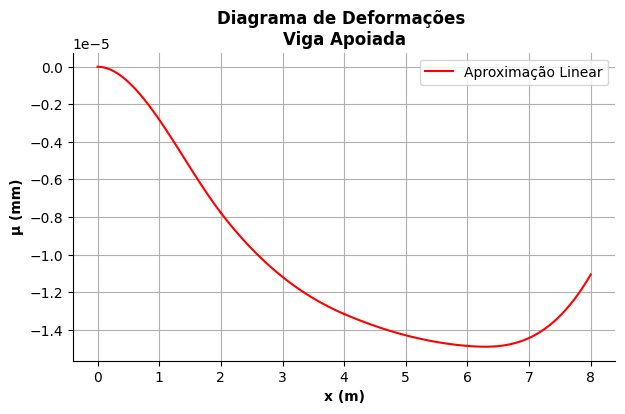

In [16]:
# Plotagem dos deslocamentos
# Definir vetor x contendo pontos no domínio da viga
#xx = np.linspace(0, 3, 100)
#E,A,q0,L,s0=200e9,50e-6,10e3,3,100e6
# Plotagem da função u: solução analítica
#plt.plot(xx, (-q0*xx**3/(6*A*E) + xx*(2*A*s0 + L**2*q0)/(2*A*E)), label='solução analítica')
# Plotagem da função u: aproximação por MEF

plt.figure(figsize = (7, 4))
for elm in range(n_el):

    no1=conec[elm,2]
    no2=conec[elm,3]

    L_e=abs(x[no2] - x[no1])

    u1 = desloc[2*no1]
    u2 = desloc[2*no1+1]
    u3 = desloc[2*no2]
    u4 = desloc[2*no2+1]

    u_e=np.array([u1,  u2, u3, u4])
    npontos=30

    xe = np.linspace(-L_e/2, L_e/2, npontos)
    auxue=np.zeros(npontos)

    for ii in range(npontos):

        N = Matrix([[1/2 - 3*xe[ii]/(2*L_e) + 2*xe[ii]**3/L_e**3, L_e/8 - xe[ii]/4 - xe[ii]**2/(2*L_e) + xe[ii]**3/L_e**2, 1/2 + 3*xe[ii]/(2*L_e) - 2*xe[ii]**3/L_e**3, -L_e/8 - xe[ii]/4 + xe[ii]**2/(2*L_e) + xe[ii]**3/L_e**2]])
        
        auxue[ii]=np.dot(N,u_e)

    auxxe=(elm)*L_e+L_e/2+xe

    if elm==n_el-1:

        plt.plot(auxxe,auxue,color='red', label='aproximação MEF')

    else:

        plt.plot(auxxe,auxue,color='red')

plt.xlabel('x (m)', weight = 'bold')
plt.ylabel('μ (mm)', weight = 'bold')
plt.title('Diagrama de Deformações \nViga Apoiada', fontsize = 12, weight = 'bold')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)

plt.legend(['Aproximação Linear'])
plt.grid(True)
plt.show()

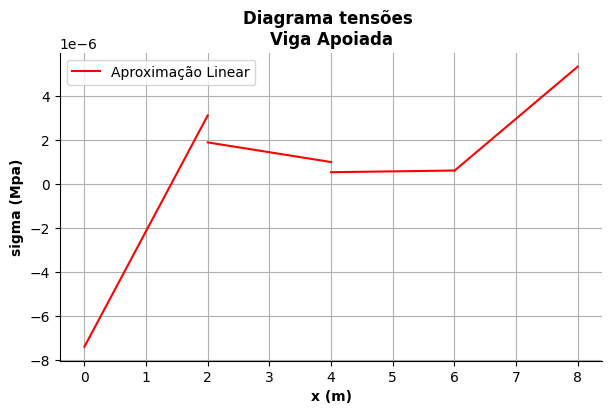

In [19]:
# Plotagem dos deslocamentos
# Definir vetor x contendo pontos no domínio da viga
#xx = np.linspace(0, 3, 100)
#E,A,q0,L,s0=200e9,50e-6,10e3,3,100e6
# Plotagem da função u: solução analítica
#plt.plot(xx, (-q0*xx**3/(6*A*E) + xx*(2*A*s0 + L**2*q0)/(2*A*E)), label='solução analítica')
# Plotagem da função u: aproximação por MEF

plt.figure(figsize = (7, 4))
for elm in range(n_el):

    no1=conec[elm,2]
    no2=conec[elm,3]

    L_e=abs(x[no2] - x[no1])

    u1 = desloc[2*no1]
    u2 = desloc[2*no1+1]
    u3 = desloc[2*no2]
    u4 = desloc[2*no2+1]

    u_e=np.array([u1,  u2, u3, u4])
    npontos= 30

    xe = np.linspace(-L_e/2, L_e/2, npontos)
    auxue=np.zeros(npontos)

    for ii in range(npontos):

        B = Matrix([[12*xe[ii]/L_e**3, (-1 + 6*xe[ii]/L_e)/L_e, -12*xe[ii]/L_e**3, (1 + 6*xe[ii]/L_e)/L_e]])

        auxue[ii]=np.dot(B,u_e)

    auxxe=(elm)*L_e+L_e/2+xe

    if elm==n_el-1:

        plt.plot(auxxe,auxue,color='red', label='aproximação MEF')

    else:

        plt.plot(auxxe,auxue,color='red')

plt.xlabel('x (m)', weight = 'bold')
plt.ylabel('sigma (Mpa)', weight = 'bold')
plt.title('Diagrama tensões \nViga Apoiada', fontsize = 12, weight = 'bold')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)

plt.legend(['Aproximação Linear'])
plt.grid(True)
plt.show()

In [3]:
from sympy import symbols, Eq, solve, exp, sin, cos
import numpy as np

b = 0.2
h = 0.6

# Assumed global variable values for demonstration
# These would need to be provided by the user for actual use.
E = 200e9
L = 8
I = b* h**3 / 12
q0 = -5000
F0 = -2000
M0 = 4000
cf = 4e8

# Calculate constants based on the provided global variables
r = (np.sqrt(2)/2)*((cf/(E*I))**(1/4))
A = sin(r*L) / cos(r*L)
B = -(M0*np.exp(r*L))/(2*(r**2)*E*I*cos(r*L))
G = (F0*np.exp(r*L))/(2*(r**3)*E*I*cos(r*L))

# Define the symbols for the unknown constants
C1, C2, C3, C4 = symbols('C1 C2 C3 C4', real=True)

# Equations based on boundary conditions
eqn1 = Eq(C1 + C3, -q0/cf)
eqn2 = Eq(C1 + C2 - C3 + C4, 0)
eqn3 = Eq(-A*C1*exp(2*r*L) + C2*exp(2*r*L) + A*C3 - C4, B)
eqn4 = Eq((1+A)*C1*exp(2*r*L) - (1-A)*C2*exp(2*r*L) - (1-A)*C3 - (1+A)*C4, G)

# Solve the system of equations
solutions = solve((eqn1, eqn2, eqn3, eqn4), (C1, C2, C3, C4))
solutions

{C1: -7.20819430431765e-8,
 C2: 9.05670004604173e-8,
 C3: 1.25720819430432e-5,
 C4: 1.25535968856259e-5}

In [21]:
# Re-defining the constants with the correct values
b = 0.2
h = 0.6
E = 200e9
L = 8
I = b * h**3 / 12
q0 = -5000
F0 = -2000
M0 = 4000
cf = 4e8

# Calculating the constants again with the updated values
r = (np.sqrt(2)/2)*((cf/(E*I))**(1/4))
A = sin(r*L) / cos(r*L)
B = -(M0*np.exp(r*L))/(2*(r**2)*E*I*cos(r*L))
G = (F0*np.exp(r*L))/(2*(r**3)*E*I*cos(r*L))

# Solve the system of equations again
C1, C2, C3, C4 = symbols('C1 C2 C3 C4', real=True)
eqn1 = Eq(C1 + C3, -q0/cf)
eqn2 = Eq(C1 + C2 - C3 + C4, 0)
eqn3 = Eq(-A*C1*exp(2*r*L) + C2*exp(2*r*L) + A*C3 - C4, B)
eqn4 = Eq((1+A)*C1*exp(2*r*L) - (1-A)*C2*exp(2*r*L) - (1-A)*C3 - (1+A)*C4, G)
solutions = solve((eqn1, eqn2, eqn3, eqn4), (C1, C2, C3, C4))

# Extracting the solutions to use for deflection calculations
c1 = float(solutions[C1])
c2 = float(solutions[C2])
c3 = float(solutions[C3])
c4 = float(solutions[C4])

# Function to calculate deflection y at a point x
def deflection(x):
    f1 = np.exp(r*x)*(c1*np.cos(r*x) + c2*np.sin(r*x))
    f2 = np.exp(-r*x)*(c3*np.cos(r*x) + c4*np.sin(r*x))
    return f1 + f2 + (q0/cf)

# Function to calculate moment (tension) M at a point x
def moment(x):
    M1 = -E*I*r*(c1*np.exp(r*x)*(r*np.sin(r*x) - np.cos(r*x)) + c2*np.exp(r*x)*(r*np.cos(r*x) + np.sin(r*x)))
    M2 = E*I*r*(c3*np.exp(-r*x)*(r*np.sin(r*x) + np.cos(r*x)) + c4*np.exp(-r*x)*(r*np.cos(r*x) - np.sin(r*x)))
    return M1 + M2

# Define the x points to evaluate the functions
x_points = np.linspace(0, L, 100)  # 100 points between 0 and L

# Calculate deflection and moment for each x point
y_deflection = np.array([deflection(x) for x in x_points])
y_moment = np.array([moment(x) for x in x_points])

# Since we can't plot inside this environment, we will prepare the data for plotting externally
x_points, y_deflection, y_moment

(array([0.        , 0.08080808, 0.16161616, 0.24242424, 0.32323232,
        0.4040404 , 0.48484848, 0.56565657, 0.64646465, 0.72727273,
        0.80808081, 0.88888889, 0.96969697, 1.05050505, 1.13131313,
        1.21212121, 1.29292929, 1.37373737, 1.45454545, 1.53535354,
        1.61616162, 1.6969697 , 1.77777778, 1.85858586, 1.93939394,
        2.02020202, 2.1010101 , 2.18181818, 2.26262626, 2.34343434,
        2.42424242, 2.50505051, 2.58585859, 2.66666667, 2.74747475,
        2.82828283, 2.90909091, 2.98989899, 3.07070707, 3.15151515,
        3.23232323, 3.31313131, 3.39393939, 3.47474747, 3.55555556,
        3.63636364, 3.71717172, 3.7979798 , 3.87878788, 3.95959596,
        4.04040404, 4.12121212, 4.2020202 , 4.28282828, 4.36363636,
        4.44444444, 4.52525253, 4.60606061, 4.68686869, 4.76767677,
        4.84848485, 4.92929293, 5.01010101, 5.09090909, 5.17171717,
        5.25252525, 5.33333333, 5.41414141, 5.49494949, 5.57575758,
        5.65656566, 5.73737374, 5.81818182, 5.89

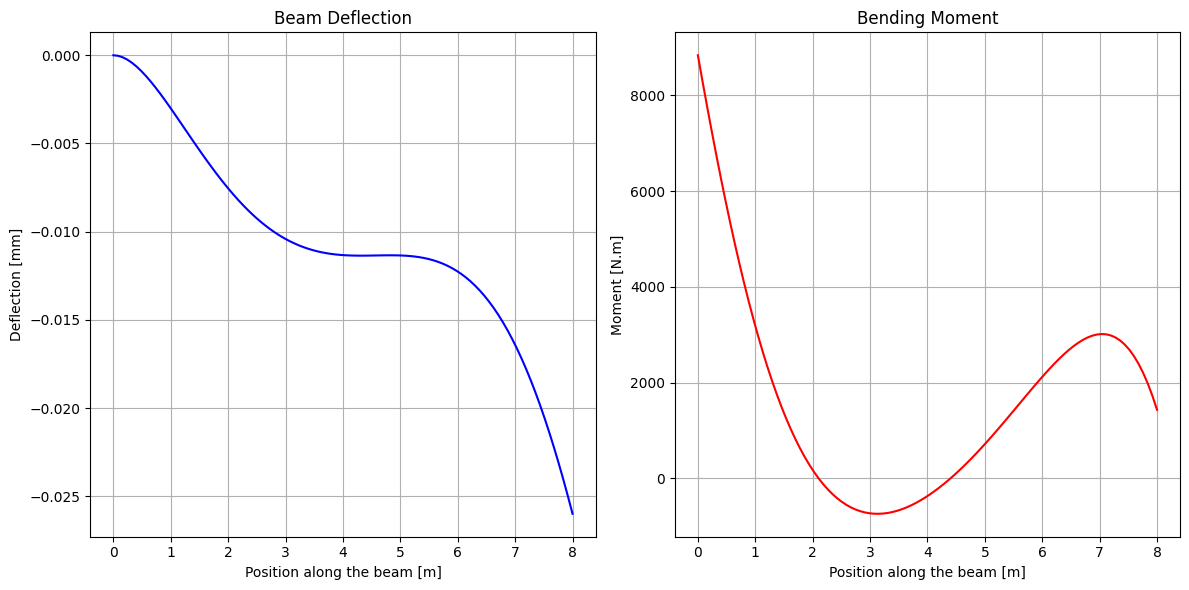

In [22]:
import matplotlib.pyplot as plt

# Assuming x_points, y_deflection, and y_moment are the arrays obtained from the previous output
# Convert deflection from meters to millimeters for a more conventional plot
y_deflection_mm = y_deflection * 1000

# Plotting the deflection
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_points, y_deflection_mm, 'b')
plt.title('Beam Deflection')
plt.xlabel('Position along the beam [m]')
plt.ylabel('Deflection [mm]')
plt.grid(True)

# Plotting the moment
plt.subplot(1, 2, 2)
plt.plot(x_points, y_moment, 'r')
plt.title('Bending Moment')
plt.xlabel('Position along the beam [m]')
plt.ylabel('Moment [N.m]')
plt.grid(True)

plt.tight_layout()
plt.show()

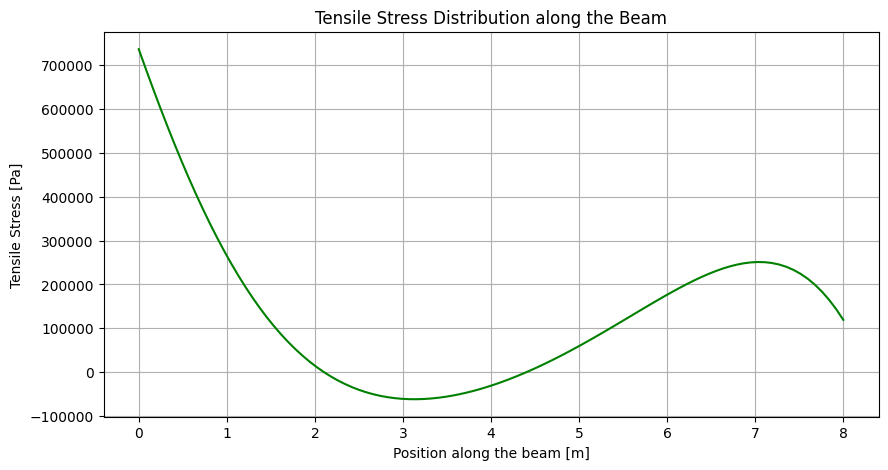

In [24]:
# Distance from the neutral axis to the furthest fiber (top or bottom of the beam) in meters
y_max = h / 2

# Calculate the maximum tensile stress at each point using the bending moment
tension_stress = y_moment * y_max / I

# Since we can't plot inside this environment, we will prepare the data for plotting externally
tension_stress


# Plotting the tensile stress
plt.figure(figsize=(10, 5))
plt.plot(x_points, tension_stress, 'g')
plt.title('Tensile Stress Distribution along the Beam')
plt.xlabel('Position along the beam [m]')
plt.ylabel('Tensile Stress [Pa]')
plt.grid(True)
plt.show()

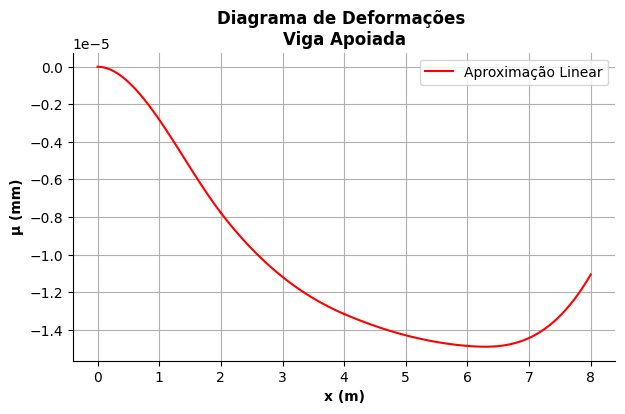

IndexError: list index out of range

<Figure size 700x400 with 0 Axes>

KeyboardInterrupt: 

In [20]:
import matplotlib.pyplot as plt

# Assuming x_points, y_deflection, and y_moment are the arrays obtained from the previous output
# Convert deflection from meters to millimeters for a more conventional plot
y_deflection_mm = y_deflection * 1000

# Plotting the deflection
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_points, y_deflection_mm, 'b')
plt.title('Beam Deflection')
plt.xlabel('Position along the beam [m]')
plt.ylabel('Deflection [mm]')
plt.grid(True)

# Plotting the moment
plt.subplot(1, 2, 2)
plt.plot(x_points, y_moment, 'r')
plt.title('Bending Moment')
plt.xlabel('Position along the beam [m]')
plt.ylabel('Moment [N.m]')
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'y_deflection' is not defined